In [ ]:
!pip install opacus
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [ ]:
!pip install -q kaggle

from google.colab import files
uploaded = files.upload()

import os
os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'wb') as f:
    f.write(uploaded['kaggle.json'])

!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip -qq celeba-dataset.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other


In [ ]:
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import os
import time
from opacus import PrivacyEngine
from tabulate import tabulate

In [ ]:
NUM_CLIENTS = 5
BATCH_SIZE = 64
EPOCHS = 7
MAX_SAMPLES = 20000
NUM_ROUNDS = 5

In [ ]:
class CelebADataset(Dataset):
    def __init__(self, img_dir, attr_path, transform=None, max_samples=None):
        self.img_dir = img_dir
        self.attributes = pd.read_csv(attr_path)
        self.transform = transform

        if max_samples is not None:
            self.attributes = self.attributes.iloc[:max_samples]

        # Convert attributes to binary (0, 1)
        self.attributes.replace(to_replace=-1, value=0, inplace=True)

    def __len__(self):
        return len(self.attributes)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.attributes.iloc[idx, 0])
        image = Image.open(img_name)
        attrs = self.attributes.iloc[idx, 1:].values.astype('float32')

        if self.transform:
            image = self.transform(image)

        return image, attrs

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
            nn.PReLU(out_channels)
        )

    def forward(self, x):
        return self.block(x)

class MobileFaceNet(nn.Module):
    def __init__(self, embedding_size=128):
        super().__init__()
        self.conv1 = ConvBlock(3, 64, stride=2)
        self.conv2 = ConvBlock(64, 64, stride=1)
        self.conv3 = ConvBlock(64, 128, stride=2)
        self.conv4 = ConvBlock(128, 128, stride=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, embedding_size)
        self.classifier = nn.Linear(embedding_size, 40)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool(x).view(x.size(0), -1)
        x = self.fc(x)
        return self.classifier(x)

In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    criterion = nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for images, targets in dataloader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets.float())
            total_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).int()
            total += targets.size(0) * targets.size(1)
            correct += (preds == targets.int()).sum().item()

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(dataloader)
    return avg_loss, accuracy

def evaluate_robustness(model, dataloader, device, noise_level=0.1):
    model.eval()
    correct = 0
    total = 0
    criterion = nn.BCEWithLogitsLoss()
    total_loss = 0

    with torch.no_grad():
        for images, targets in dataloader:
            noisy_images = images + torch.randn_like(images) * noise_level
            noisy_images = torch.clamp(noisy_images, 0, 1)

            noisy_images, targets = noisy_images.to(device), targets.to(device)
            outputs = model(noisy_images)
            loss = criterion(outputs, targets.float())
            total_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).int()
            total += targets.size(0) * targets.size(1)
            correct += (preds == targets.int()).sum().item()

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(dataloader)
    return avg_loss, accuracy

def calculate_communication_cost(model):
    total_bytes = 0
    for param in model.parameters():
        total_bytes += param.numel() * 4
    return total_bytes / (1024 * 1024)

def secure_aggregate(models):
    agg_model = copy.deepcopy(models[0])
    for key in agg_model.keys():
        for i in range(1, len(models)):
            agg_model[key] += models[i][key]
        agg_model[key] = torch.div(agg_model[key], len(models))
    return agg_model

def remove_module_prefix(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith("_module."):
            new_state_dict[k.replace("_module.", "")] = v
        else:
            new_state_dict[k] = v
    return new_state_dict

In [ ]:
def train_dp(model, train_loader, val_loader, criterion, device, dp=True):
    model.train()
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    privacy_engine = None
    if dp:
        privacy_engine = PrivacyEngine()
        model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
            module=model,
            optimizer=optimizer,
            data_loader=train_loader,
            target_epsilon=10.0,
            target_delta=1e-5,
            epochs=EPOCHS,
            max_grad_norm=1.0
        )

    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_accs = []
    epoch_val_accs = []

    for epoch in range(EPOCHS):
        model.train()
        running_loss, correct, total = 0, 0, 0

        for images, targets in train_loader:
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            total += targets.numel()
            correct += (preds == targets.int()).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        val_loss, val_acc = evaluate(model, val_loader, device)

        epoch_train_losses.append(train_loss)
        epoch_val_losses.append(val_loss)
        epoch_train_accs.append(train_acc)
        epoch_val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{EPOCHS}: "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    epsilon = None
    if dp and privacy_engine:
        epsilon = privacy_engine.get_epsilon(delta=1e-5)
        print(f"Privacy spent: ε = {epsilon:.2f}, δ = 1e-5")

    return model.cpu().state_dict(), epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs, epsilon

In [ ]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
])

img_dir = 'img_align_celeba/img_align_celeba'
attr_path = 'list_attr_celeba.csv'
celeba_full = CelebADataset(img_dir, attr_path, transform=transform, max_samples=MAX_SAMPLES)

indices = np.random.permutation(len(celeba_full))
client_data = [Subset(celeba_full, indices[i::NUM_CLIENTS]) for i in range(NUM_CLIENTS)]

# Initialize global model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_model = MobileFaceNet().to(device)
criterion = nn.BCEWithLogitsLoss()

print("Global model initialized:")

=val_size = int(0.1 * len(celeba_full))
train_val_size = len(celeba_full) - val_size
train_val_dataset, val_dataset = torch.utils.data.random_split(celeba_full, [train_val_size, val_size])

indices = np.random.permutation(len(train_val_dataset))
client_data = [Subset(train_val_dataset, indices[i::NUM_CLIENTS]) for i in range(NUM_CLIENTS)]

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

print(f"\nTraining/Validation split: {len(train_val_dataset)} train, {len(val_dataset)} validation")
print(f"Validation loader batches: {len(val_loader)}")

# Initialize metrics storage
all_rounds_metrics = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'epsilon': [],
    'communication_cost': [],
    'robustness_loss': [],
    'robustness_acc': [],
    'training_time': []
}

initial_comm_cost = calculate_communication_cost(global_model)
print(f"\nInitial model communication cost: {initial_comm_cost:.2f} MB")

Global model initialized:

Training/Validation split: 18000 train, 2000 validation
Validation loader batches: 32

Initial model communication cost: 1.08 MB


In [ ]:
for round in range(NUM_ROUNDS):
    print(f"\n=== Federated Round {round+1}/{NUM_ROUNDS} ===")
    round_start_time = time.time()

    local_models = []
    round_metrics = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'epsilon': []
    }

    # Client training
    for client_idx in range(NUM_CLIENTS):
        print(f"\n--- Client {client_idx+1} Training ---")
        local_model = copy.deepcopy(global_model)
        train_loader = DataLoader(client_data[client_idx], batch_size=BATCH_SIZE, shuffle=True)

        state_dict, train_losses, val_losses, train_accs, val_accs, epsilon = train_dp(
            local_model, train_loader, val_loader, criterion, device, dp=True
        )

        local_models.append(state_dict)
        round_metrics['train_loss'].extend(train_losses)
        round_metrics['val_loss'].extend(val_losses)
        round_metrics['train_acc'].extend(train_accs)
        round_metrics['val_acc'].extend(val_accs)
        if epsilon is not None:
            round_metrics['epsilon'].append(epsilon)

    global_weights = secure_aggregate(local_models)
    clean_weights = remove_module_prefix(global_weights)
    global_model.load_state_dict(clean_weights)

    # Calculate round metrics
    round_time = time.time() - round_start_time
    comm_cost = calculate_communication_cost(global_model) * NUM_CLIENTS * 2

    robustness_loss, robustness_acc = evaluate_robustness(global_model, val_loader, device)

    # Store metrics
    all_rounds_metrics['train_loss'].append(np.mean(round_metrics['train_loss']))
    all_rounds_metrics['val_loss'].append(np.mean(round_metrics['val_loss']))
    all_rounds_metrics['train_acc'].append(np.mean(round_metrics['train_acc']))
    all_rounds_metrics['val_acc'].append(np.mean(round_metrics['val_acc']))
    all_rounds_metrics['epsilon'].append(np.mean(round_metrics['epsilon']) if round_metrics['epsilon'] else 0)
    all_rounds_metrics['communication_cost'].append(comm_cost)
    all_rounds_metrics['robustness_loss'].append(robustness_loss)
    all_rounds_metrics['robustness_acc'].append(robustness_acc)
    all_rounds_metrics['training_time'].append(round_time)

    print(f"\nRound {round+1} Summary:")
    print(f"Avg Train Loss: {all_rounds_metrics['train_loss'][-1]:.4f}")
    print(f"Avg Val Loss: {all_rounds_metrics['val_loss'][-1]:.4f}")
    print(f"Avg Train Acc: {all_rounds_metrics['train_acc'][-1]:.2f}%")
    print(f"Avg Val Acc: {all_rounds_metrics['val_acc'][-1]:.2f}%")
    print(f"Robustness Loss: {robustness_loss:.4f}, Robustness Acc: {robustness_acc:.2f}%")
    print(f"Privacy ε: {all_rounds_metrics['epsilon'][-1]:.2f}")
    print(f"Communication Cost: {comm_cost:.2f} MB")
    print(f"Round Time: {round_time:.2f} seconds")


=== Federated Round 1/5 ===

--- Client 1 Training ---


/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 1/7: Train Loss: 0.4705, Val Loss: 0.4333 | Train Acc: 79.32%, Val Acc: 80.15%
Epoch 2/7: Train Loss: 0.4261, Val Loss: 0.4326 | Train Acc: 80.55%, Val Acc: 80.42%
Epoch 3/7: Train Loss: 0.4251, Val Loss: 0.4324 | Train Acc: 80.50%, Val Acc: 80.41%
Epoch 4/7: Train Loss: 0.4241, Val Loss: 0.4322 | Train Acc: 80.61%, Val Acc: 80.41%
Epoch 5/7: Train Loss: 0.4259, Val Loss: 0.4319 | Train Acc: 80.65%, Val Acc: 80.41%
Epoch 6/7: Train Loss: 0.4270, Val Loss: 0.4318 | Train Acc: 80.65%, Val Acc: 80.41%
Epoch 7/7: Train Loss: 0.4268, Val Loss: 0.4321 | Train Acc: 80.62%, Val Acc: 80.45%
Privacy spent: ε = 9.99, δ = 1e-5

--- Client 2 Training ---
Epoch 1/7: Train Loss: 0.4718, Val Loss: 0.4330 | Train Acc: 79.48%, Val Acc: 80.15%
Epoch 2/7: Train Loss: 0.4223, Val Loss: 0.4335 | Train Acc: 80.71%, Val Acc: 80.15%
Epoch 3/7: Train Loss: 0.4262, Val Loss: 0.4327 | Train Acc: 80.49%, Val Acc: 80.42%
Epoch 4/7: Train Loss: 0.4251, Val Loss: 0.4332 | Train Acc: 80.54%, Val Acc: 80.21%
Epoc

In [ ]:
# Print round-by-round table
headers = ["Round", "Train Loss", "Val Loss", "Robust Loss",
           "Train Acc", "Val Acc", "Robust Acc",
           "Privacy ε", "Comm Cost (MB)", "Time (s)"]
table_data = []
for round in range(NUM_ROUNDS):
    table_data.append([
        round+1,
        f"{all_rounds_metrics['train_loss'][round]:.4f}",
        f"{all_rounds_metrics['val_loss'][round]:.4f}",
        f"{all_rounds_metrics['robustness_loss'][round]:.4f}",
        f"{all_rounds_metrics['train_acc'][round]:.2f}%",
        f"{all_rounds_metrics['val_acc'][round]:.2f}%",
        f"{all_rounds_metrics['robustness_acc'][round]:.2f}%",
        f"{all_rounds_metrics['epsilon'][round]:.2f}",
        f"{all_rounds_metrics['communication_cost'][round]:.2f}",
        f"{all_rounds_metrics['training_time'][round]:.2f}"
    ])

print("\n=== Round-by-Round Metrics ===")
print(tabulate(table_data, headers=headers, tablefmt="grid"))


=== Round-by-Round Metrics ===
+---------+--------------+------------+---------------+-------------+-----------+--------------+-------------+------------------+------------+
|   Round |   Train Loss |   Val Loss |   Robust Loss | Train Acc   | Val Acc   | Robust Acc   |   Privacy ε |   Comm Cost (MB) |   Time (s) |
+=========+==============+============+===============+=============+===========+==============+=============+==================+============+
|       1 |       0.4325 |     0.4324 |        0.435  | 80.44%      | 80.37%    | 80.45%       |        9.99 |            10.78 |     460.15 |
+---------+--------------+------------+---------------+-------------+-----------+--------------+-------------+------------------+------------+
|       2 |       0.424  |     0.4312 |        0.433  | 80.77%      | 80.54%    | 80.63%       |        9.99 |            10.78 |     460.29 |
+---------+--------------+------------+---------------+-------------+-----------+--------------+-------------+

In [ ]:
# Print comprehensive final metrics
print("\n" + "="*80)
print("FINAL MODEL EVALUATION SUMMARY".center(80))
print("="*80)

# Final test evaluation
test_loader = DataLoader(Subset(celeba_full, indices[:1000]), batch_size=64)
test_loss, test_acc = evaluate(global_model, test_loader, device)
robustness_loss, robustness_acc = evaluate_robustness(global_model, test_loader, device)

# Calculate totals
total_comm_cost = sum(all_rounds_metrics['communication_cost'])
total_time = sum(all_rounds_metrics['training_time'])
final_epsilon = max(all_rounds_metrics['epsilon']) if all_rounds_metrics['epsilon'] else 0
model_size = calculate_communication_cost(global_model)

print("\n=== Performance Metrics ===")
print(f"{'Final Test Loss:':<25} {test_loss:.4f}")
print(f"{'Final Test Accuracy:':<25} {test_acc:.2f}%")
print(f"{'Robustness Test Loss:':<25} {robustness_loss:.4f}")
print(f"{'Robustness Test Accuracy:':<25} {robustness_acc:.2f}%")

print("\n=== Efficiency Metrics ===")
print(f"{'Total Communication Cost:':<25} {total_comm_cost:.2f} MB")
print(f"{'Final Model Size:':<25} {model_size:.2f} MB")
print(f"{'Total Training Time:':<25} {total_time:.2f} seconds")

print("\n=== Privacy Metrics ===")
print(f"{'Final Privacy Guarantee (ε):':<25} {final_epsilon:.2f}")
print(f"{'Privacy Delta (δ):':<25} 1e-5")


                         FINAL MODEL EVALUATION SUMMARY                         

=== Performance Metrics ===
Final Test Loss:          0.4278
Final Test Accuracy:      80.77%
Robustness Test Loss:     0.4280
Robustness Test Accuracy: 80.71%

=== Efficiency Metrics ===
Total Communication Cost: 53.90 MB
Final Model Size:         1.08 MB
Total Training Time:      2297.33 seconds

=== Privacy Metrics ===
Final Privacy Guarantee (ε): 9.99
Privacy Delta (δ):        1e-5


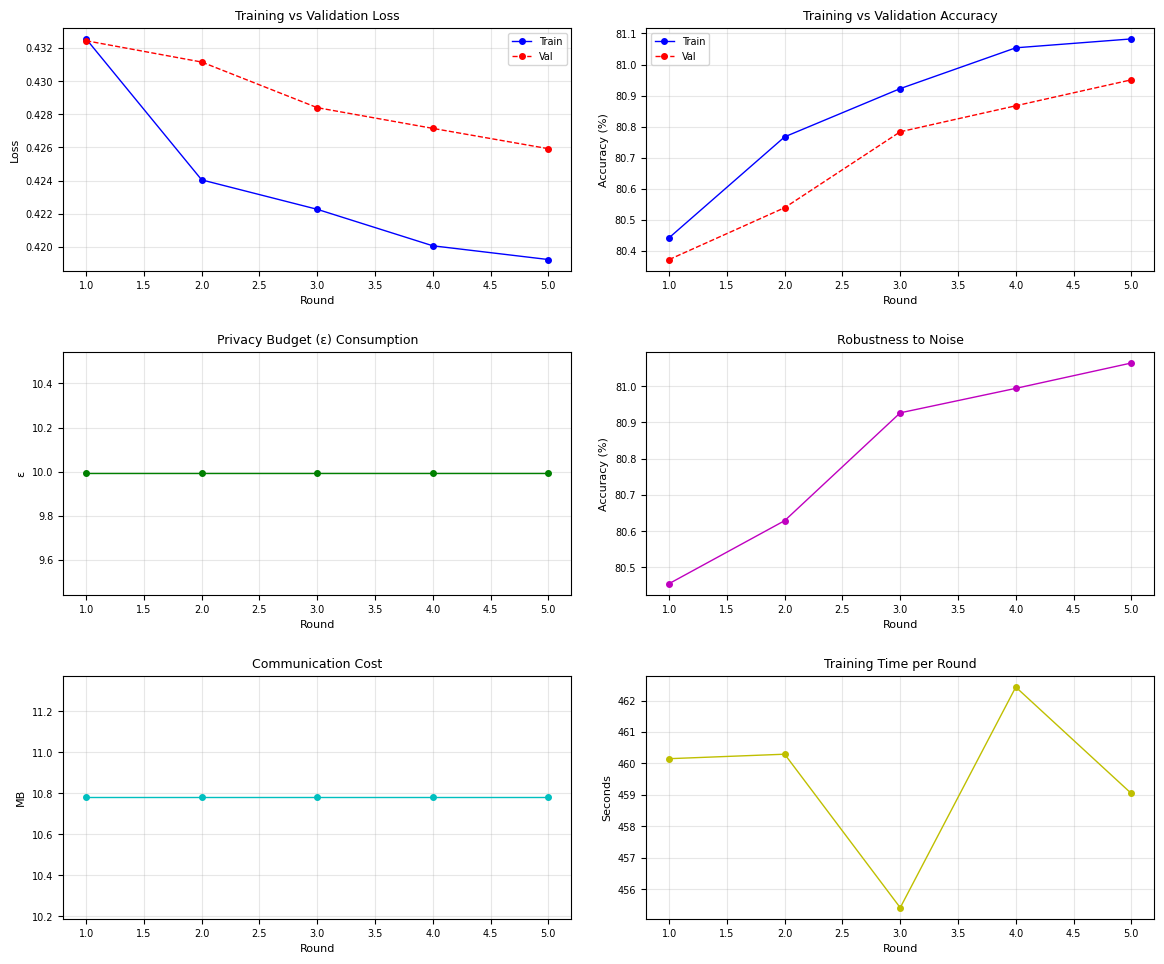

In [ ]:
plt.figure(figsize=(12, 10))

# Loss Progression
plt.subplot(3, 2, 1)
plt.plot(range(1, NUM_ROUNDS+1), all_rounds_metrics['train_loss'], 'b-o', linewidth=1, markersize=4, label='Train')
plt.plot(range(1, NUM_ROUNDS+1), all_rounds_metrics['val_loss'], 'r--o', linewidth=1, markersize=4, label='Val')
plt.title('Training vs Validation Loss', fontsize=9)
plt.xlabel('Round', fontsize=8)
plt.ylabel('Loss', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=7)

# Accuracy Progression
plt.subplot(3, 2, 2)
plt.plot(range(1, NUM_ROUNDS+1), all_rounds_metrics['train_acc'], 'b-o', linewidth=1, markersize=4, label='Train')
plt.plot(range(1, NUM_ROUNDS+1), all_rounds_metrics['val_acc'], 'r--o', linewidth=1, markersize=4, label='Val')
plt.title('Training vs Validation Accuracy', fontsize=9)
plt.xlabel('Round', fontsize=8)
plt.ylabel('Accuracy (%)', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=7)

# Privacy Loss
plt.subplot(3, 2, 3)
plt.plot(range(1, NUM_ROUNDS+1), all_rounds_metrics['epsilon'], 'g-o', linewidth=1, markersize=4)
plt.title('Privacy Budget (ε) Consumption', fontsize=9)
plt.xlabel('Round', fontsize=8)
plt.ylabel('ε', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.grid(True, alpha=0.3)

# Robustness-
plt.subplot(3, 2, 4)
plt.plot(range(1, NUM_ROUNDS+1), all_rounds_metrics['robustness_acc'], 'm-o', linewidth=1, markersize=4)
plt.title('Robustness to Noise', fontsize=9)
plt.xlabel('Round', fontsize=8)
plt.ylabel('Accuracy (%)', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.grid(True, alpha=0.3)

# Communication Cost
plt.subplot(3, 2, 5)
plt.plot(range(1, NUM_ROUNDS+1), all_rounds_metrics['communication_cost'], 'c-o', linewidth=1, markersize=4)
plt.title('Communication Cost', fontsize=9)
plt.xlabel('Round', fontsize=8)
plt.ylabel('MB', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.grid(True, alpha=0.3)

# Training Time
plt.subplot(3, 2, 6)
plt.plot(range(1, NUM_ROUNDS+1), all_rounds_metrics['training_time'], 'y-o', linewidth=1, markersize=4)
plt.title('Training Time per Round', fontsize=9)
plt.xlabel('Round', fontsize=8)
plt.ylabel('Seconds', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.grid(True, alpha=0.3)

plt.tight_layout(pad=2.0)
plt.show()